# Import

In [144]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time


import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import Tuple, NoReturn
import seaborn as sns


# Dataloader

In [145]:
#Transforms from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_dataset,validation_dataset = random_split(train_dataset,[round(0.9 * len(train_dataset)), round(0.1 * len(train_dataset))])

Files already downloaded and verified
Files already downloaded and verified


In [146]:
BATCH_SIZE = 128
SHUFFLE = True
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=SHUFFLE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Visualizing Data

# Model

In [147]:
class SCNN(nn.Module):
    def __init__(self, activation: str, batch_norm: str, dropout: bool) -> None:
        super().__init__()

        #BASE MODEL
     
        #VGG Style architecture

        #Conv Block 1
        #(Nx3x32x32) -> (Nx32x16x16)
        conv1_1 = nn.Conv2d(in_channels=3, out_channels=32,
                          kernel_size=3, padding=1)
        conv1_2 = nn.Conv2d(in_channels=32, out_channels=32,
                          kernel_size=3, padding=1)
        pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 2
        #(Nx32x16x16) -> (Nx64x8x8)
        conv2_1 = nn.Conv2d(in_channels=32, out_channels=64,
                            kernel_size=3, padding=1)
        conv2_2 = nn.Conv2d(in_channels=64, out_channels=64,
                            kernel_size=3, padding=1)
        pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        #Conv Block 3
        #(Nx64x8x8) -> (Nx128x4x4)
        conv3_1 = nn.Conv2d(in_channels=64, out_channels=128,
                            kernel_size=3, padding=1)
        conv3_2 = nn.Conv2d(in_channels=128, out_channels=128,
                            kernel_size=3, padding=1)
        pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        in_dim = 128*4*4
        fc1 = nn.Linear(in_dim,128)
        fc2 = nn.Linear(128,10)

        activation_layer = None
        dropout_layer = None
        if activation == 'relu':
            activation_layer = nn.ReLU()
        elif activation == 'lrelu':
            activation_layer = nn.LeakyReLU()
        else:
            if activation == 'elu':
                activation_layer = nn.ELU()


        self.conv_net = nn.Sequential(conv1_1,
                                      activation_layer,
                                      conv1_2,
                                      activation_layer,
                                      pool1,
                                      conv2_1,
                                      activation_layer,
                                      conv2_2,
                                      activation_layer,
                                      pool2,
                                      conv3_1,
                                      activation_layer,
                                      conv3_2,
                                      activation_layer,
                                      pool3,
                                      nn.Flatten(start_dim=1),
                                      fc1,
                                      activation_layer,
                                      fc2)

        if batch_norm == 'bnorm':
            bnorm1_1 = nn.BatchNorm2d(32)
            bnorm1_2 = nn.BatchNorm2d(32)
            bnorm2_1 = nn.BatchNorm2d(64)
            bnorm2_2 = nn.BatchNorm2d(64)
            bnorm3_1 = nn.BatchNorm2d(128)
            bnorm3_2 = nn.BatchNorm2d(128)

            self.conv_net = nn.Sequential(conv1_1,
                                          bnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          bnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          bnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          bnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          bnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          bnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)
        elif batch_norm == 'gnorm':

            gnorm1_1 = nn.GroupNorm(8, 32)
            gnorm1_2 = nn.GroupNorm(8, 32)
            gnorm2_1 = nn.GroupNorm(8, 64)
            gnorm2_2 = nn.GroupNorm(8, 64)
            gnorm3_1 = nn.GroupNorm(8, 128)
            gnorm3_2 = nn.GroupNorm(8, 128)

            self.conv_net = nn.Sequential(conv1_1,
                                          gnorm1_1,
                                          activation_layer,
                                          conv1_2,
                                          gnorm1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          gnorm2_1,
                                          activation_layer,
                                          conv2_2,
                                          gnorm2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          gnorm3_1,
                                          activation_layer,
                                          conv3_2,
                                          gnorm3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          fc1,
                                          activation_layer,
                                          fc2)

        else:
            pass


        if dropout == True :
            print("CNN with dropout ")
            dropout_layer = nn.Dropout(0.5)
            dropout_layer1 = nn.Dropout(0.3)
            self.conv_net = nn.Sequential(conv1_1,
                                          activation_layer,
                                          conv1_2,
                                          activation_layer,
                                          pool1,
                                          conv2_1,
                                          activation_layer,
                                          conv2_2,
                                          activation_layer,
                                          pool2,
                                          conv3_1,
                                          activation_layer,
                                          conv3_2,
                                          activation_layer,
                                          pool3,
                                          nn.Flatten(start_dim=1),
                                          dropout_layer,
                                          fc1,
                                          activation_layer,
                                          dropout_layer1,
                                          fc2)


        else:
            print("CNN with no dropout")
            pass






        #############################################################################################
        #Add dropout in similar way, so one code for all
        ###############################################################################################

    def forward(self, x):
        
        
        y = self.conv_net(x)

        return y

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [148]:
cnn = SCNN(activation='relu',batch_norm= 'gnorm' ,dropout=False)
params = count_model_params(cnn)
print(cnn)
print(f"Model has {params} learnable parameters")


CNN with no dropout
SCNN(
  (conv_net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GroupNorm(8, 32, eps=1e-05, affine=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): GroupNorm(8, 64, eps=1e-05, affine=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): GroupNorm(8, 64, eps=1e-05, affine=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GroupNorm(8, 128, eps=1e-05, affine=True)
    (16): ReLU()
    (17): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

# Training

## Parameters for training

In [149]:
LR = 3e-4
EPOCHS = 50
EVAL_FREQ = 1
SAVE_FREQ = 10
val_loss = 1000

In [150]:
stats = {
    "epoch": [],
    "train_loss": [],
    "valid_loss": [],
    "accuracy": [],
    "parameters" : 0.0
}
init_epoch = 0

In [151]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = cnn.to(device)

In [152]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)

In [153]:
@torch.no_grad()
def eval_model(model):
    correct = 0
    total = 0
    loss_list = []

    model.eval()
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    model.train()
    return accuracy, loss


def save_model(model, optimizer, epoch, stats, val,time):
    """ Saving model checkpoint """
    if(not os.path.exists("models")):
        os.makedirs("models")
    if (val):

        savepath = f"models/best_val_{stats['model']}.pth"

        torch.save({
            'time' : time,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)
        
    else:

        savepath = f"models/{stats['model']}_checkpoint_epoch_{epoch}.pth"

        torch.save({
            'time' : time,
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats': stats
        }, savepath)

    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """

    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    time = checkpoint["time"]

    return model, optimizer, epoch, stats,time


def test_model(model):

    correct = 0
    total = 0
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len(torch.where(preds == labels)[0])
        total += len(labels)

    # Total correct predictions and loss
    accuracy = correct / total * 100
    model.train()
    return accuracy

In [154]:
loss_hist = []
stats['model'] = 'gnorm'
stats['parameters'] = params
start = time.perf_counter()


for epoch in range(EPOCHS):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i,(images,labels) in progress_bar:

        loss_list = []

        x = images.to(device)
        y_train = labels.to(device)
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = cnn(x)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, y_train)

        # Getting gradients w.r.t. parameters
        loss.backward()
        loss_list.append(loss.item())

        # Updating parameters
        optimizer.step()
        progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
    
    loss_hist.append(np.mean(loss_list))
    stats["epoch"].append(epoch)
    stats["train_loss"].append(loss_hist[-1])
    

    if epoch % EVAL_FREQ == 0:
        accuracy, valid_loss = eval_model(cnn)
        print(f"training loss : {loss_hist[-1]}  ,  validation loss : {valid_loss}")
        print(f"Accuracy at epoch {epoch}: {round(accuracy, 2)}%")
    else:
        accuracy, valid_loss = -1, -1
    
    stats["accuracy"].append(accuracy)
    stats["valid_loss"].append(valid_loss)


    #Saving best validation model
    if valid_loss < val_loss:
        val_loss = valid_loss
        end = time.perf_counter()
        save_model(model=cnn, optimizer=optimizer,
                   epoch=epoch, stats=stats, val = True, time = end - start )


    if epoch % SAVE_FREQ == 0:

        end = time.perf_counter()
        save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats,val = False, time = end - start)

end = time.perf_counter()
time = end - start
save_model(model=cnn, optimizer=optimizer, epoch=epoch, stats=stats, val=False, time = time)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 1 Iter 352: loss 1.19537. : 100%|██████████| 352/352 [00:24<00:00, 14.44it/s]


training loss : 1.1953740119934082  ,  validation loss : 1.1644865572452545
Accuracy at epoch 0: 58.58%


Epoch 2 Iter 352: loss 0.89903. : 100%|██████████| 352/352 [00:24<00:00, 14.55it/s]


training loss : 0.8990298509597778  ,  validation loss : 0.9447118446230889
Accuracy at epoch 1: 67.04%


Epoch 3 Iter 352: loss 0.77980. : 100%|██████████| 352/352 [00:24<00:00, 14.63it/s]


training loss : 0.7797976732254028  ,  validation loss : 0.8662879526615143
Accuracy at epoch 2: 69.32%


Epoch 4 Iter 352: loss 0.76350. : 100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


training loss : 0.7635014057159424  ,  validation loss : 0.7664098933339119
Accuracy at epoch 3: 72.82%


Epoch 5 Iter 352: loss 0.67492. : 100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


training loss : 0.674923300743103  ,  validation loss : 0.7778880074620247
Accuracy at epoch 4: 72.64%


Epoch 6 Iter 352: loss 0.47688. : 100%|██████████| 352/352 [00:24<00:00, 14.61it/s]


training loss : 0.47688382863998413  ,  validation loss : 0.7504729375243187
Accuracy at epoch 5: 74.92%


Epoch 7 Iter 352: loss 0.39032. : 100%|██████████| 352/352 [00:24<00:00, 14.53it/s]


training loss : 0.39032167196273804  ,  validation loss : 0.6945006996393204
Accuracy at epoch 6: 76.0%


Epoch 8 Iter 352: loss 0.31023. : 100%|██████████| 352/352 [00:24<00:00, 14.59it/s]


training loss : 0.31023305654525757  ,  validation loss : 0.718185105919838
Accuracy at epoch 7: 75.14%


Epoch 9 Iter 352: loss 0.44116. : 100%|██████████| 352/352 [00:24<00:00, 14.59it/s]


training loss : 0.44115808606147766  ,  validation loss : 0.693914569914341
Accuracy at epoch 8: 77.26%


Epoch 10 Iter 352: loss 0.29862. : 100%|██████████| 352/352 [00:24<00:00, 14.51it/s]


training loss : 0.2986213266849518  ,  validation loss : 0.6947365969419479
Accuracy at epoch 9: 77.3%


Epoch 11 Iter 352: loss 0.39031. : 100%|██████████| 352/352 [00:24<00:00, 14.55it/s]


training loss : 0.39031243324279785  ,  validation loss : 0.7522921800613404
Accuracy at epoch 10: 77.32%


Epoch 12 Iter 352: loss 0.30599. : 100%|██████████| 352/352 [00:24<00:00, 14.66it/s]


training loss : 0.3059873580932617  ,  validation loss : 0.7566384017467499
Accuracy at epoch 11: 77.24%


Epoch 13 Iter 352: loss 0.16825. : 100%|██████████| 352/352 [00:24<00:00, 14.60it/s]


training loss : 0.16824834048748016  ,  validation loss : 0.7740645438432694
Accuracy at epoch 12: 77.26%


Epoch 14 Iter 352: loss 0.11683. : 100%|██████████| 352/352 [00:24<00:00, 14.62it/s]


training loss : 0.11682923883199692  ,  validation loss : 0.8390066251158714
Accuracy at epoch 13: 76.5%


Epoch 15 Iter 352: loss 0.09998. : 100%|██████████| 352/352 [00:24<00:00, 14.65it/s]


training loss : 0.09997723251581192  ,  validation loss : 0.9740141302347183
Accuracy at epoch 14: 74.14%


Epoch 16 Iter 352: loss 0.17127. : 100%|██████████| 352/352 [00:24<00:00, 14.65it/s]


training loss : 0.17127251625061035  ,  validation loss : 0.9129693508148193
Accuracy at epoch 15: 76.18%


Epoch 17 Iter 352: loss 0.11380. : 100%|██████████| 352/352 [00:24<00:00, 14.64it/s]


training loss : 0.11380203813314438  ,  validation loss : 0.9322257868945598
Accuracy at epoch 16: 76.82%


Epoch 18 Iter 352: loss 0.05033. : 100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


training loss : 0.05033378303050995  ,  validation loss : 0.9552926421165466
Accuracy at epoch 17: 76.04%


Epoch 19 Iter 352: loss 0.12727. : 100%|██████████| 352/352 [00:24<00:00, 14.55it/s]


training loss : 0.1272655576467514  ,  validation loss : 1.059553611278534
Accuracy at epoch 18: 74.86%


Epoch 20 Iter 352: loss 0.14124. : 100%|██████████| 352/352 [00:24<00:00, 14.58it/s]


training loss : 0.1412404477596283  ,  validation loss : 0.9574590466916562
Accuracy at epoch 19: 75.92%


Epoch 21 Iter 352: loss 0.06902. : 100%|██████████| 352/352 [00:24<00:00, 14.60it/s]


training loss : 0.06901538372039795  ,  validation loss : 0.9842420950531959
Accuracy at epoch 20: 77.5%


Epoch 22 Iter 352: loss 0.04038. : 100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


training loss : 0.04037801921367645  ,  validation loss : 1.0211361795663834
Accuracy at epoch 21: 77.72%


Epoch 23 Iter 352: loss 0.00187. : 100%|██████████| 352/352 [00:24<00:00, 14.61it/s]


training loss : 0.0018672134028747678  ,  validation loss : 1.0663894325494767
Accuracy at epoch 22: 78.42%


Epoch 24 Iter 352: loss 0.00095. : 100%|██████████| 352/352 [00:23<00:00, 14.67it/s]


training loss : 0.0009470371878705919  ,  validation loss : 1.003696869313717
Accuracy at epoch 23: 78.94%


Epoch 25 Iter 352: loss 0.00177. : 100%|██████████| 352/352 [00:24<00:00, 14.54it/s]


training loss : 0.0017698761075735092  ,  validation loss : 1.0258122444152833
Accuracy at epoch 24: 79.02%


Epoch 26 Iter 352: loss 0.00112. : 100%|██████████| 352/352 [00:24<00:00, 14.51it/s]


training loss : 0.001121332636103034  ,  validation loss : 1.0613581404089927
Accuracy at epoch 25: 79.06%


Epoch 27 Iter 352: loss 0.00060. : 100%|██████████| 352/352 [00:24<00:00, 14.56it/s]


training loss : 0.0005987779004499316  ,  validation loss : 1.0339484512805939
Accuracy at epoch 26: 79.2%


Epoch 28 Iter 352: loss 0.00044. : 100%|██████████| 352/352 [00:24<00:00, 14.64it/s]


training loss : 0.0004435399314388633  ,  validation loss : 1.0346663862466812
Accuracy at epoch 27: 79.08%


Epoch 29 Iter 352: loss 0.00046. : 100%|██████████| 352/352 [00:24<00:00, 14.56it/s]


training loss : 0.00046474707778543234  ,  validation loss : 1.1039551988244056
Accuracy at epoch 28: 78.94%


Epoch 30 Iter 352: loss 0.00035. : 100%|██████████| 352/352 [00:24<00:00, 14.54it/s]


training loss : 0.000347118970239535  ,  validation loss : 1.078371898829937
Accuracy at epoch 29: 79.06%


Epoch 31 Iter 352: loss 0.00041. : 100%|██████████| 352/352 [00:24<00:00, 14.55it/s]


training loss : 0.0004082649538759142  ,  validation loss : 1.119828462600708
Accuracy at epoch 30: 79.14%


Epoch 32 Iter 352: loss 0.00040. : 100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


training loss : 0.0004019533807877451  ,  validation loss : 1.1070379465818405
Accuracy at epoch 31: 79.22%


Epoch 33 Iter 352: loss 0.00017. : 100%|██████████| 352/352 [00:24<00:00, 14.47it/s]


training loss : 0.00017471431056037545  ,  validation loss : 1.1093945011496544
Accuracy at epoch 32: 79.1%


Epoch 34 Iter 352: loss 0.00013. : 100%|██████████| 352/352 [00:24<00:00, 14.51it/s]


training loss : 0.00013152362953405827  ,  validation loss : 1.1411994978785516
Accuracy at epoch 33: 79.0%


Epoch 35 Iter 352: loss 0.00015. : 100%|██████████| 352/352 [00:24<00:00, 14.52it/s]


training loss : 0.00015087048814166337  ,  validation loss : 1.1349808275699615
Accuracy at epoch 34: 79.0%


Epoch 36 Iter 352: loss 0.00014. : 100%|██████████| 352/352 [00:24<00:00, 14.55it/s]


training loss : 0.000142751305247657  ,  validation loss : 1.1454230759642088
Accuracy at epoch 35: 79.1%


Epoch 37 Iter 352: loss 0.00013. : 100%|██████████| 352/352 [00:24<00:00, 14.57it/s]


training loss : 0.0001339539303444326  ,  validation loss : 1.1935592338442802
Accuracy at epoch 36: 79.06%


Epoch 38 Iter 352: loss 0.00009. : 100%|██████████| 352/352 [00:24<00:00, 14.59it/s]


training loss : 8.64882895257324e-05  ,  validation loss : 1.233658504486084
Accuracy at epoch 37: 79.08%


Epoch 39 Iter 352: loss 0.00007. : 100%|██████████| 352/352 [00:24<00:00, 14.52it/s]


training loss : 7.46634032111615e-05  ,  validation loss : 1.2505224272608757
Accuracy at epoch 38: 78.92%


Epoch 40 Iter 352: loss 0.00007. : 100%|██████████| 352/352 [00:24<00:00, 14.48it/s]


training loss : 6.904167094035074e-05  ,  validation loss : 1.2239950135350228
Accuracy at epoch 39: 79.04%


Epoch 41 Iter 352: loss 0.00006. : 100%|██████████| 352/352 [00:24<00:00, 14.44it/s]


training loss : 5.636991045321338e-05  ,  validation loss : 1.2334631107747556
Accuracy at epoch 40: 79.06%


Epoch 42 Iter 352: loss 0.00005. : 100%|██████████| 352/352 [00:24<00:00, 14.41it/s]


training loss : 5.1760958740487695e-05  ,  validation loss : 1.3074875235557557
Accuracy at epoch 41: 79.04%


Epoch 43 Iter 352: loss 0.00005. : 100%|██████████| 352/352 [00:24<00:00, 14.48it/s]


training loss : 4.5949909690534696e-05  ,  validation loss : 1.2676994308829308
Accuracy at epoch 42: 79.06%


Epoch 44 Iter 352: loss 0.00003. : 100%|██████████| 352/352 [00:24<00:00, 14.44it/s]


training loss : 2.932429197244346e-05  ,  validation loss : 1.292661216855049
Accuracy at epoch 43: 78.94%


Epoch 45 Iter 352: loss 0.00003. : 100%|██████████| 352/352 [00:24<00:00, 14.46it/s]


training loss : 3.118654421996325e-05  ,  validation loss : 1.370310890674591
Accuracy at epoch 44: 79.0%


Epoch 46 Iter 352: loss 0.00003. : 100%|██████████| 352/352 [00:24<00:00, 14.49it/s]


training loss : 2.5139042918453924e-05  ,  validation loss : 1.359554871916771
Accuracy at epoch 45: 79.04%


Epoch 47 Iter 352: loss 0.00002. : 100%|██████████| 352/352 [00:24<00:00, 14.50it/s]


training loss : 1.7051332179107703e-05  ,  validation loss : 1.3680347353219986
Accuracy at epoch 46: 78.78%


Epoch 48 Iter 352: loss 0.00002. : 100%|██████████| 352/352 [00:24<00:00, 14.48it/s]


training loss : 1.671864629315678e-05  ,  validation loss : 1.395697270333767
Accuracy at epoch 47: 79.12%


Epoch 49 Iter 352: loss 0.00001. : 100%|██████████| 352/352 [00:24<00:00, 14.45it/s]


training loss : 1.242071175511228e-05  ,  validation loss : 1.385921885073185
Accuracy at epoch 48: 78.86%


Epoch 50 Iter 352: loss 0.00001. : 100%|██████████| 352/352 [00:24<00:00, 14.43it/s]


training loss : 1.3089525054965634e-05  ,  validation loss : 1.3840334874286782
Accuracy at epoch 49: 79.02%


# Testing

In [175]:
cnn = SCNN(activation='relu',batch_norm= None ,dropout=False)
cnn = cnn.to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)
savepath = os.path.join(os.getcwd(), "models/", "best_val_naiive.pth")
model,optimizer,epoch,stats,time= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
final_accuracy = test_model(model)
print(f"final acc : {final_accuracy}")

cnn = SCNN(activation='relu',batch_norm= None ,dropout=True)
cnn = cnn.to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)
savepath = os.path.join(os.getcwd(), "models/", "best_val_dropout.pth")
model1,optimizer1,epoch1,stats1,time1= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
final_accuracy1 = test_model(model1)
print(f"final acc : {final_accuracy1}")

CNN with no dropout


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


final acc : 73.06
CNN with dropout 
final acc : 81.84


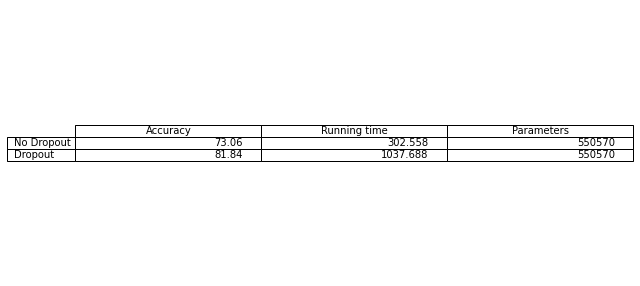

In [210]:
columns = ('Accuracy', 'Running time', 'Parameters')
rows = ["No Dropout", "Dropout"]
cell_text = [[final_accuracy, round(time,3),stats['parameters']], [final_accuracy1,round(time1,3),stats1['parameters']]]
# Add a table at the bottom of the axes
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=cell_text,
                     colLabels=columns,rowLabels = rows,loc='center')
the_table.auto_set_font_size(False) 
the_table.set_fontsize(10) 
plt.show()


In [216]:
cnn = SCNN(activation='relu',batch_norm= 'bnorm' ,dropout=False)
cnn = cnn.to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)
savepath = os.path.join(os.getcwd(), "models/", "best_val_bnorm.pth")
model2,optimizer2,epoch2,stats2,time2= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
final_accuracy2 = test_model(model2)
print(f"final acc : {final_accuracy2}")

cnn = SCNN(activation='relu',batch_norm= 'gnorm' ,dropout=False)
cnn = cnn.to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=LR)
savepath = os.path.join(os.getcwd(), "models/", "best_val_gnorm.pth")
model3,optimizer3,epoch3,stats3,time3= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
final_accuracy3 = test_model(model3)
print(f"final acc : {final_accuracy3}")

CNN with no dropout


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


final acc : 78.11
CNN with no dropout
final acc : 77.60000000000001


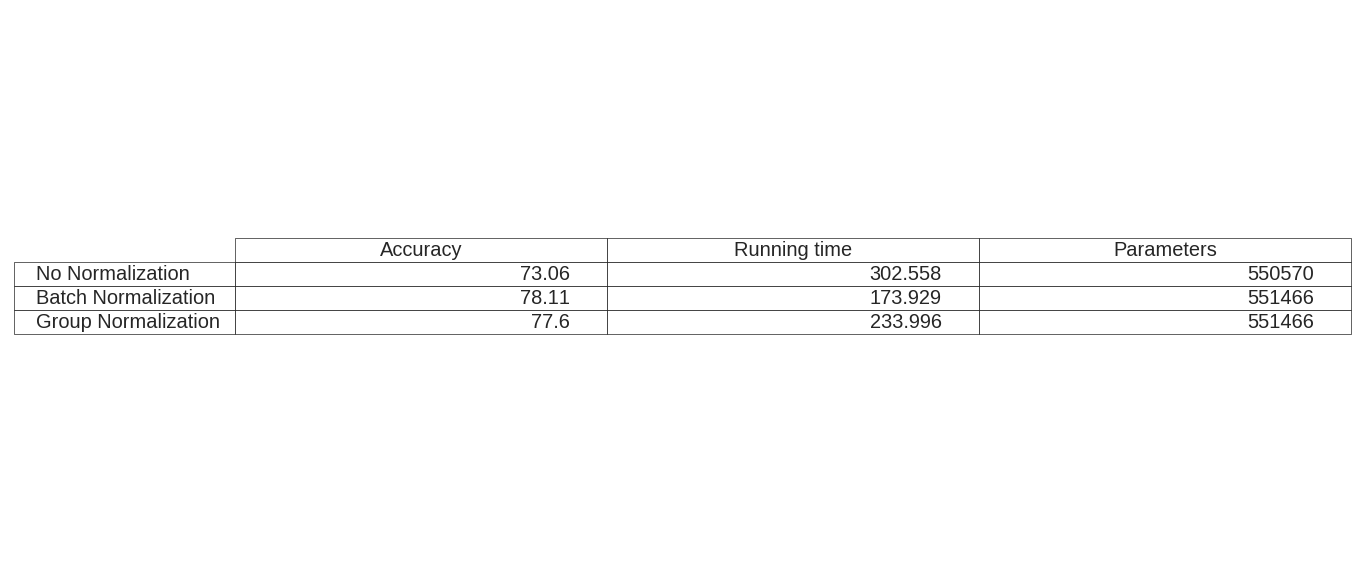

In [219]:
columns = ('Accuracy', 'Running time', 'Parameters')
rows = ["No Normalization", "Batch Normalization", "Group Normalization"]
cell_text = [[final_accuracy, round(time,3),stats['parameters']], [final_accuracy2,round(time2,3),stats2['parameters']], [round(final_accuracy3,4),round(time3,3),stats3['parameters']]]
# Add a table at the bottom of the axes
fig, ax = plt.subplots()
fig.set_size_inches(10,5)
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=cell_text,
                     colLabels=columns,rowLabels = rows,loc='center')
the_table.auto_set_font_size(False) 
the_table.set_fontsize(10) 
plt.show()

# Activation Visualization

In [176]:
# savepath = os.path.join(os.getcwd(), "models/", "best_val_dropout.pth")
# model1,optimizer1,epoch1,stats1,time1= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
# savepath = os.path.join(os.getcwd(), "models/", "best_val_naiive.pth")
# model2,optimizer2,epoch2,stats2,time2= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
# savepath = os.path.join(os.getcwd(), "models/", "best_val_bnorm.pth")
# model3,optimizer3,epoch3,stats3,time3= load_model(model=cnn,optimizer=optimizer,savepath=savepath)
# savepath = os.path.join(os.getcwd(), "models/", "best_val_gnorm.pth")
# model4,optimizer4,epoch4,stats4,time4= load_model(model=cnn,optimizer=optimizer,savepath=savepath)

In [157]:
print(time4)

233.99614345700047


In [177]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
# Visualize feature maps
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [178]:
datait = iter(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [179]:
images,labels = datait.next()


In [180]:
#Code from https://discuss.pytorch.org/t/visualize-feature-map/29597/6 {PyTorch Forum}
activation = {}
model.conv_net[0].register_forward_hook(get_activation('activation_conv1_1'))
model.conv_net[3].register_forward_hook(get_activation('activation_conv1_2'))
model.conv_net[7].register_forward_hook(get_activation('activation_conv2_1'))
model.conv_net[10].register_forward_hook(get_activation('activation_conv2_2'))
model.conv_net[14].register_forward_hook(get_activation('activation_conv3_1'))
model.conv_net[17].register_forward_hook(get_activation('activation_conv3_2'))

output = model(images[0].unsqueeze(0).to(device))
# print(output.shape)




AttributeError: ignored

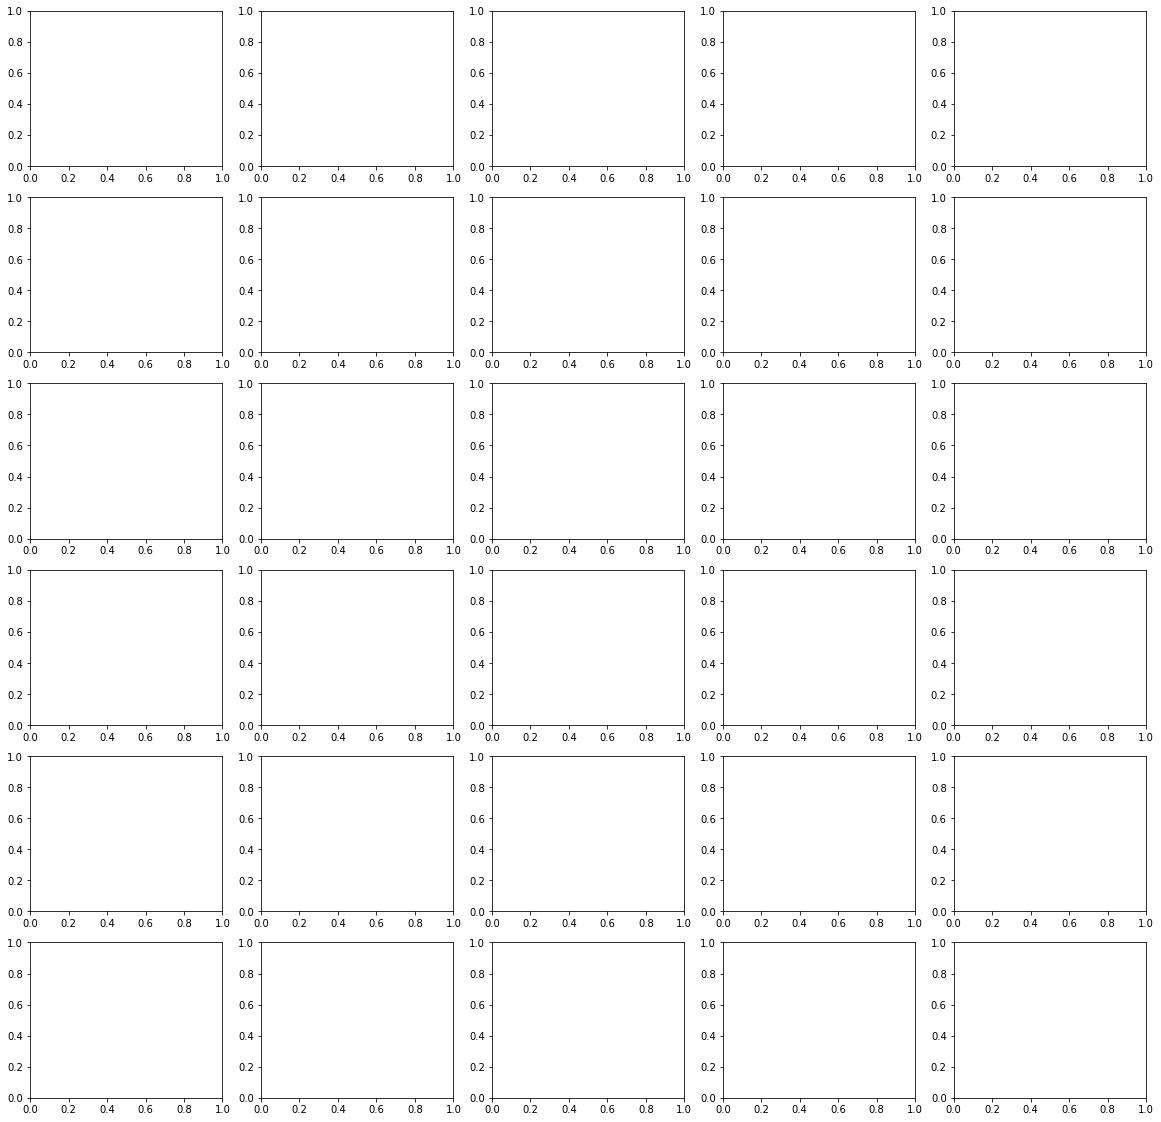

In [181]:
num_plot = 5
fig, axarr = plt.subplots(6, num_plot, figsize=(20, 20))
fig.supxlabel('Different Channels')
fig.supylabel('Activations of Conv layer')
fig.tight_layout()

for cnt,(k, v) in zip(range(6),activation.items()):
    act = activation[k].squeeze()    
    for idx in range(num_plot):
        axarr[cnt,idx].imshow(act[idx].cpu().numpy(),cmap="gray")

# Kernel Visualization 

In [182]:
# https: // github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

def plot_rgb(weights):
   
    n_filters = 5
    fig,ax = plt.subplots(1,n_filters,figsize = (8,8))


    for i in range(n_filters):
        weight = weights[i]
        weight = weight - torch.min(weight)
        weight = weight / torch.max(weight)
        # weight.shape
       
        ax[i].imshow(weight.permute(1,2,0).cpu().numpy())
    plt.show()

def plot_single_channel(weights):

    n_filters = 5
    n_channels = 5
    fig, ax = plt.subplots(n_filters, n_channels,figsize=(8, 8))

    for i in  range(n_filters):
        for j in range(n_channels):
            # print(i,j)
            weight = weights[i,j]
            weight = weight - torch.min(weight)
            weight = weight / torch.max(weight)

            ax[i,j].imshow(weight.cpu().numpy())
            ax[i, j].axis('off')
            ax[i, j].set_title(str(i)+str(j))
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    
    # plt.tight_layout()
    plt.show()


In [183]:
def plot_weights(model,layer_num):

    layer = model.conv_net[layer_num]
    print(layer)
    
    if isinstance(layer,nn.Conv2d):
        weight_tensor = layer.weight.data.detach()
 
        if weight_tensor.shape[1] == 3:
            plot_rgb(weight_tensor)
        else:
            
            plot_single_channel(weight_tensor)



Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


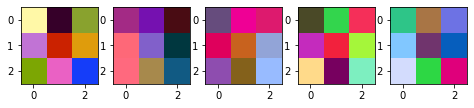

ReLU()
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


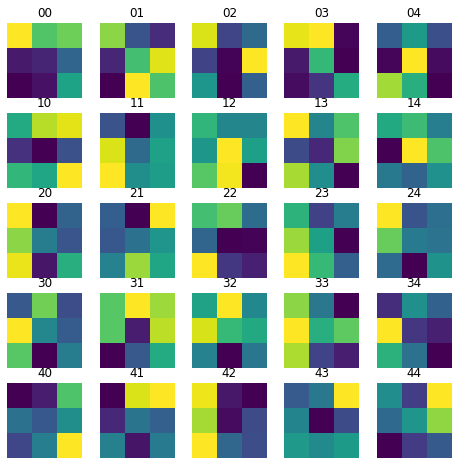

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


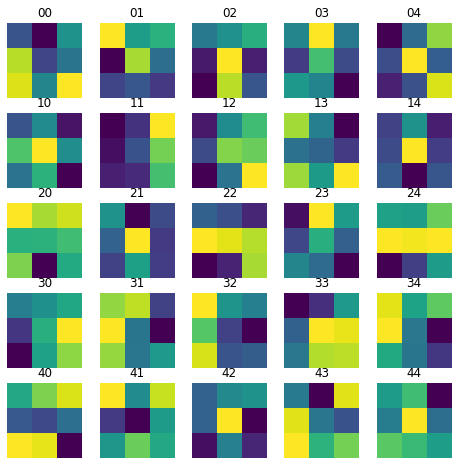

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
ReLU()


In [184]:
plot_weights(model,0)
plot_weights(model,3)
plot_weights(model,7)
plot_weights(model,10)
plot_weights(model,14)
plot_weights(model, 17)
